In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

from dataclasses import dataclass
from functools import partial

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [99]:
def taylor(x, N):
    return jax.lax.fori_loop(1, N, lambda i, val: val + (x ** i) / i, 0)

    # use scan instead:
    # return jax.lax.scan(lambda i, val: val + (x ** i) / i, 0, jnp.arange(1, N))[1]

fwd_taylor = jax.jit(jax.jacfwd(taylor, argnums=0))

In [100]:
# gtaylor(0.5, 10000)

In [101]:
@partial(jax.jit, static_argnums=1)
def taylor(x, N):

    def body(val, i):
        res = val + x ** i / i 
        return res, res

    return jax.lax.scan(body, 0, jnp.arange(1, N))[0]

@partial(jax.jit, static_argnums=1)
def rev_taylor(x, N):
    return jax.grad(taylor, argnums=0)(x, N)

# rev_taylor = jax.jit(jax.grad(taylor, argnums=0))
# rev_taylor = jax.jit(jax.grad(taylor, argnums=0))

In [102]:
taylor(0.5, 10000)

DeviceArray(0.6931473, dtype=float32)

In [103]:
rev_taylor(0.5, 10000)

DeviceArray(2., dtype=float32, weak_type=True)

In [104]:
jax.value_and_grad(lambda y, x: jnp.sin(x) * y)(0.5, 1.0)

(DeviceArray(0.4207355, dtype=float32, weak_type=True),
 DeviceArray(0.841471, dtype=float32, weak_type=True))

In [105]:
jax.value_and_grad(lambda x,y: jnp.power(2.0, x) / y)(0.8, 0.5)

(DeviceArray(3.4822023, dtype=float32, weak_type=True),
 DeviceArray(2.4136786, dtype=float32, weak_type=True))

In [106]:
# Black Scholes
# helper analytics    
@jit
def bsPrice(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    d2 = d1 - vol * jnp.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

@jit
def bsDelta(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    return norm.cdf(d1)

@jit
def bsVega(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    return spot * jnp.sqrt(T) * norm.pdf(d1)

@dataclass
class BlackScholes:
    
    spot: int = 1
    vol: float = 0.2
    T1: int = 1
    T2: int = 2
    K: float = 1.10
    volMult: float = 1.5
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    # @partial(jit, static_argnums=(0,))
    def trainingSet(self, m, anti=True, seed=42):
    
        key = random.PRNGKey(seed)
        # 2 sets of normal returns
        returns = random.normal(key, shape=(m, 2))

        # SDE
        vol0 = self.vol * self.volMult
        R1 = jnp.exp(-0.5*vol0*vol0*self.T1 + vol0*jnp.sqrt(self.T1)*returns[:,0])
        R2 = jnp.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*jnp.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = jnp.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = jnp.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*jnp.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = jnp.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  jnp.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  jnp.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  jnp.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=42):
        
        spots = jnp.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas   

In [107]:
bs = BlackScholes()
x_train, y_train, dydx_train = bs.trainingSet(8192)
x_test, x_axis, y_test, dydx_test, vegas = bs.testSet(num=1000)

In [108]:
def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test):
    plt.title("Training Data")
    # the same as plt.scatter(x_train, y_train) but with a thinner line is:
    plt.plot(x_train, y_train, 'r.', markersize=1)
    # now the other two with a thinner line:
    plt.plot(x_test, y_test, 'b.', markersize=1)
    plt.plot(x_train, dydx_train, 'g.', markersize=1)
    # plt.plot(x_axis, dydx_test, 'g.', markersize=1)
    # corresponding legend:
    plt.legend(['Training Data', 'True Price', 'Training Delta'], loc='upper left')
    plt.show()

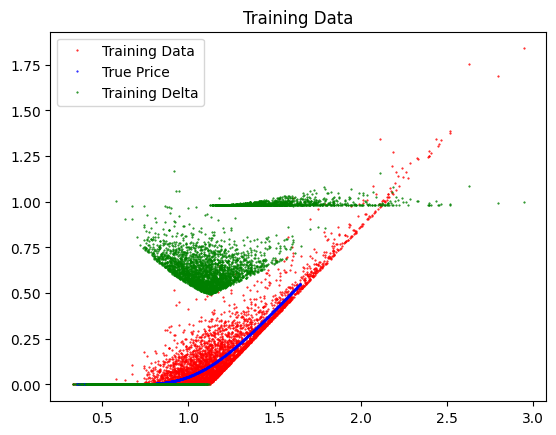

In [109]:
plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test)

In [110]:
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(x_train)
y_train, y_train_mean, y_train_std = normalize(y_train)
dydx_train, dydx_train_mean, dydx_train_std = normalize(dydx_train)

In [111]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 10
seed = 42

key = jax.random.PRNGKey(seed)

In [112]:
x = jnp.array([1, 2, 3])[..., jnp.newaxis]
print(x.shape)
x.ndim

(3, 1)


2

In [113]:
# this is the first change: we use an out_size of 2 to predict both the price and the delta


key, subkey = jax.random.split(key)
model = eqx.nn.MLP(key=subkey, in_size=1, out_size=2, width_size=20, depth=3, activation=jax.nn.elu)

# adapt model to use glorot initialization in eqx:

# model_one = eqx.nn.MLP(key=key, in_size=1, out_size=1, width_size=20, depth=3, activation=jax.nn.elu)

In [114]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  print(out, in_)
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

key, subkey = jax.random.split(key)

model = init_linear_weight(model, trunc_init, key)


20 1
20 20
20 20
2 20


In [115]:
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)
    pred = vmap(model)(x)
    y_pred, dydx_pred = pred[:, 0][..., jnp.newaxis], pred[:, 1][..., jnp.newaxis]
    # jax.debug.print("{y}", y=y_pred)
    # jax.debug.print("{y_shape}", y_shape=y_pred.shape)
    # jax.debug.print("{dydx_pred}", dydx_pred=dydx_pred)
    # jax.debug.print("{dydx_shape}", dydx_shape=dydx_pred.shape)

    loss = alpha * jnp.mean((y_pred - y)**2) + beta * jnp.mean((dydx_pred - dydx)**2)
    return loss

In [116]:
res = vmap(model)(x_train)
# res = jnp.asarray(res[:, 0][..., jnp.newaxis])
res = res[:, 0][..., jnp.newaxis]

jax.debug.print("{r}", r=res.shape)

(8192, 1)


In [117]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          dydx: Float[Array, "n"],
          optim: optax.GradientTransformation,
          steps: int
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"],
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    n_batches = (len(x) // batch_size)
    for step in range(n_batches):
        batch_x = x[step*batch_size:(step+1)*batch_size]
        batch_y = y[step*batch_size:(step+1)*batch_size]
        batch_dydx = dydx[step*batch_size:(step+1)*batch_size]

        model, opt_state, loss_value = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

        if (step % 100 == 0) or (step == steps-1):
            test_loss = loss_fn(model, (x_test - x_train_mean) / x_train_std, (y_test - y_train_mean) / y_train_std, (dydx_test - dydx_train_mean) / dydx_train_std)
            print(f"step: {step}, train_loss: {loss_value}, test_loss: {test_loss}")
    
    return model

In [118]:
optim = optax.adam(learning_rate)
model = train(model, x_train, y_train, dydx_train, optim, steps=1000)

step: 0, train_loss: 1.994680643081665, test_loss: 0.7817156314849854


(1000, 1)
RMSE: 0.009165137074887753


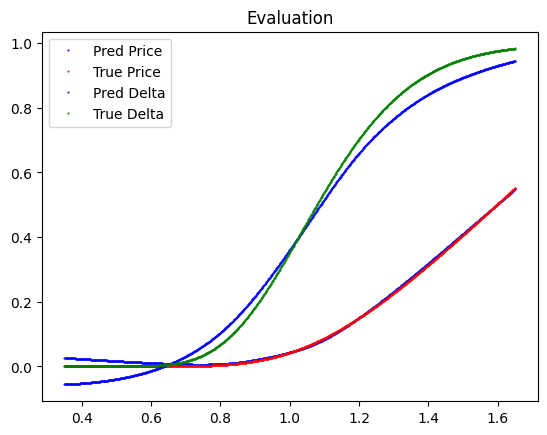

In [119]:
# predict
# x_test = x_axis
x = (x_test - x_train_mean) / x_train_std
pred = vmap(model)(x)
# unscale predictions
pred_y = pred[:, 0] * y_train_std + y_train_mean
pred_dydx = pred[:, 1] * dydx_train_std + dydx_train_mean

pred_y = pred_y[..., jnp.newaxis]
pred_dydx = pred_dydx[..., jnp.newaxis]

print(pred_y.shape)
# evaluate
def eval_rmse(y_true: Array, y_pred: Array) -> float:
    return jnp.sqrt(jnp.mean((y_true - y_pred) ** 2))

# print the above line:
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(x_test, pred_y, 'b.', markersize=1)
plt.plot(x_test, y_test, 'r.', markersize=1)
plt.plot(x_test, pred_dydx, 'b.', markersize=1)
plt.plot(x_test, dydx_test, 'g.', markersize=1)
plt.legend(['Pred Price', 'True Price', 'Pred Delta', "True Delta"], loc='upper left')
plt.show()